In [0]:
!pip install pytorch_pretrained_bert pytorch-nlp

     |████████████████████████████████| 133kB 34.2MB/s 
     |████████████████████████████████| 92kB 34.9MB/s 
     |████████████████████████████████| 655kB 35.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/35/e4/80/abf3b33ba89cf65cd262af8a22a5a999cc28fbfabea6b38473
Successfully built regex


In [0]:
%matplotlib inline
import sys
import itertools
import numpy as np
import random as rn
import matplotlib.pyplot as plt
import torch
from pytorch_pretrained_bert import BertModel
from torch import nn
from torchnlp.datasets import imdb_dataset
from pytorch_pretrained_bert import BertTokenizer
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output

Using TensorFlow backend.


In [0]:
rn.seed(321)
np.random.seed(321)
torch.manual_seed(321)
torch.cuda.manual_seed(321)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Prepare the Data

In [0]:
train_data_full, test_data_full = imdb_dataset(train=True, test=True)
rn.shuffle(train_data_full)
rn.shuffle(test_data_full)
train_data = train_data_full[:1000]
test_data = test_data_full[:1000]

aclImdb_v1.tar.gz: 84.1MB [00:09, 8.65MB/s]                            


In [0]:
train_texts, train_labels = list(zip(*map(lambda d: (d['text'], d['sentiment']), train_data)))
test_texts, test_labels = list(zip(*map(lambda d: (d['text'], d['sentiment']), test_data)))

len(train_texts), len(train_labels), len(test_texts), len(test_labels)

(1000, 1000, 1000, 1000)

In [0]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

100%|██████████| 231508/231508 [00:03<00:00, 66755.09B/s]


In [0]:
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:511], train_texts))
test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:511], test_texts))

len(train_tokens), len(test_tokens)          

(1000, 1000)

In [0]:
train_tokens_ids = list(map(tokenizer.convert_tokens_to_ids, train_tokens))
test_tokens_ids = list(map(tokenizer.convert_tokens_to_ids, test_tokens))

In [0]:
train_tokens_ids = pad_sequences(train_tokens_ids, maxlen=512, truncating="post", padding="post", dtype="int")
test_tokens_ids = pad_sequences(test_tokens_ids, maxlen=512, truncating="post", padding="post", dtype="int")

train_tokens_ids.shape, test_tokens_ids.shape

((1000, 512), (1000, 512))

In [0]:
train_y = np.array(train_labels) == 'pos'
test_y = np.array(test_labels) == 'pos'
train_y.shape, test_y.shape, np.mean(train_y), np.mean(test_y)

((1000,), (1000,), 0.489, 0.478)

In [0]:
train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
test_masks = [[float(i > 0) for i in ii] for ii in test_tokens_ids]

# Baseline

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

In [0]:
baseline_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), LogisticRegression()).fit(train_texts, train_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
baseline_predicted = baseline_model.predict(test_texts)

In [0]:
print(classification_report(test_labels, baseline_predicted))

              precision    recall  f1-score   support

         neg       0.80      0.80      0.80       522
         pos       0.78      0.79      0.78       478

    accuracy                           0.79      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.79      0.79      0.79      1000



# BERT model

In [0]:
class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.linear = nn.Linear(768, 1)
    
    def forward(self, tokens, masks=None):
        _, pooled_output = self.bert(tokens, attention_mask=masks, output_all_encoded_layers=False)
        linear_output = self.linear(pooled_output)
        return linear_output

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [0]:
bert_clf = BertBinaryClassifier()
bert_clf = bert_clf.cuda()


100%|██████████| 407873900/407873900 [00:36<00:00, 11253884.56B/s]


In [0]:
BATCH_SIZE = 4
EPOCHS = 3

In [0]:
train_tokens_tensor = torch.tensor(train_tokens_ids)
train_y_tensor = torch.tensor(train_y.reshape(-1, 1)).float()

test_tokens_tensor = torch.tensor(test_tokens_ids)
test_y_tensor = torch.tensor(test_y.reshape(-1, 1)).float()

train_masks_tensor = torch.tensor(train_masks)
test_masks_tensor = torch.tensor(test_masks)

str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'439.065088M'

In [0]:
train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)


In [0]:
optimizer = Adam(bert_clf.parameters(), lr=3e-6)

In [0]:
loss_func = nn.BCEWithLogitsLoss().cuda()

In [0]:
losses = []
steps = []
step = 0
for epoch_num in range(EPOCHS):
    bert_clf.train()
    train_loss = 0
    for step_num, batch_data in enumerate(train_dataloader):
        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
        probas = bert_clf(token_ids, masks)
        
        batch_loss = loss_func(probas, labels)
        train_loss += batch_loss.item()
        
        
        bert_clf.zero_grad()
        batch_loss.backward()
        

        clip_grad_norm_(parameters=bert_clf.parameters(), max_norm=1.0)
        optimizer.step()
        
        clear_output(wait=True)
        print('Epoch: ', epoch_num + 1)
        print("{0}/{1} loss: {2} ".format(step_num, len(train_data) / BATCH_SIZE, train_loss / (step_num + 1)))
        losses.append(batch_loss.item())
        steps.append(step)
        step += 1

Epoch:  3
249/250.0 loss: 0.2594618722572923 


In [0]:
def sigmoid(x):                                        
    return 1 / (1 + np.exp(-x))

In [0]:
bert_clf.eval()
bert_predicted = []
all_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        probas = bert_clf(token_ids, masks)
        numpy_probas = probas.cpu().detach().numpy()
        
        bert_predicted += list(sigmoid(numpy_probas[:, 0]) > 0.5)

In [0]:
print(classification_report(test_y, bert_predicted))

              precision    recall  f1-score   support

       False       0.88      0.91      0.89       522
        True       0.89      0.86      0.88       478

    accuracy                           0.89      1000
   macro avg       0.89      0.88      0.88      1000
weighted avg       0.89      0.89      0.88      1000



# Distilling BERT

In [0]:
train_dataset_for_distill = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
train_dataloader_for_distill = DataLoader(train_dataset, batch_size=BATCH_SIZE)

In [0]:
bert_clf.eval()
train_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(train_dataloader_for_distill):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        logits = bert_clf(token_ids, masks)
        numpy_logits = logits.cpu().detach().numpy()
        
        train_logits.append(numpy_logits)
train_logits = np.vstack(train_logits)

In [0]:
print(classification_report(train_y, sigmoid(train_logits[:, 0]) > 0.5))

              precision    recall  f1-score   support

       False       0.93      0.97      0.95       511
        True       0.97      0.92      0.95       489

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000



In [0]:
from sklearn.linear_model import LinearRegression

In [0]:
distilled_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), LinearRegression()).fit(train_texts, train_logits)

In [0]:
distilled_predicted_logits = distilled_model.predict(test_texts)

In [0]:
print(classification_report(test_y, sigmoid(distilled_predicted_logits[:, 0]) > 0.5))

              precision    recall  f1-score   support

       False       0.79      0.83      0.81       522
        True       0.80      0.76      0.78       478

    accuracy                           0.80      1000
   macro avg       0.80      0.80      0.80      1000
weighted avg       0.80      0.80      0.80      1000



(array([507.,  15.,   7.,   3.,   3.,   6.,   5.,  11.,  14., 429.]),
 array([-5.0739183 , -4.062655  , -3.0513911 , -2.0401278 , -1.0288641 ,
        -0.01760054,  0.993663  ,  2.0049267 ,  3.01619   ,  4.027454  ,
         5.0387173 ], dtype=float32),
 <a list of 10 Patch objects>)

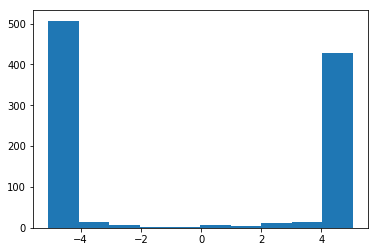

In [0]:
plt.hist(train_logits)

In [0]:
unlabeled_data = train_data_full[1000:6000]

In [0]:
unlabeled_texts, _ = list(zip(*map(lambda d: (d['text'], d['sentiment']), unlabeled_data)))

In [0]:
unlabeled_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:511], unlabeled_texts))

In [0]:
unlabeled_tokens_ids = list(map(tokenizer.convert_tokens_to_ids, unlabeled_tokens))

In [0]:
unlabeled_tokens_ids = pad_sequences(unlabeled_tokens_ids, maxlen=512, truncating="post", padding="post", dtype="int")
unlabeled_tokens_ids.shape

(5000, 512)

In [0]:
unlabeled_masks = [[float(i > 0) for i in ii] for ii in unlabeled_tokens_ids]

In [0]:
unlabeled_tokens_tensor = torch.tensor(unlabeled_tokens_ids)
unlabeled_masks_tensor = torch.tensor(unlabeled_masks)

In [0]:
unlabeled_dataset = TensorDataset(unlabeled_tokens_tensor, unlabeled_masks_tensor)
unlabeled_dataloader = DataLoader(unlabeled_dataset, batch_size=BATCH_SIZE)

In [0]:
bert_clf.eval()
unlabeled_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(unlabeled_dataloader):

        token_ids, masks = tuple(t.to(device) for t in batch_data)

        logits = bert_clf(token_ids, masks)
        numpy_logits = logits.cpu().detach().numpy()
        
        unlabeled_logits.append(numpy_logits)
        clear_output(wait=True)
        print("{0}/{1}".format(step_num, len(unlabeled_data) / BATCH_SIZE))
unlabeled_logits = np.vstack(unlabeled_logits)

1249/1250.0


In [0]:
unlabeled_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), LinearRegression()).fit(unlabeled_texts, unlabeled_logits)

In [0]:
unlabele_predicted_logits = unlabeled_model.predict(test_texts)

In [0]:
print(classification_report(test_y, sigmoid(unlabele_predicted_logits[:, 0]) > 0.5))

              precision    recall  f1-score   support

       False       0.87      0.89      0.88       522
        True       0.87      0.85      0.86       478

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000

